In [42]:
%%capture

!pip install category_encoders

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import pandas_profiling as pr
import rfpimp as rf
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import plot_partial_dependence
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, plot_confusion_matrix, plot_roc_curve, average_precision_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

# Data Wrangling

In [2]:
# Here we import the dataset.
# We also set the job_id column as the index column.

jobs_df = pd.read_csv(r"C:\Users\Andrea\GITHUB\Buld_week_unit_2\Data\fake_job_postings.csv")

# Outputs both the shape of the DF and the first
# five rows.
print(jobs_df.shape)
jobs_df.head()

(17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [3]:
# Here we view they datatype of each column as well as the
# number of non null items.

# Here we see the distribution of classes is fairly imbalanced
# with the majority being objects.

jobs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
# This will identify which columns have NaN values.
# We see that the employment_type, required_experience,
# industry and function columns have extremely large null
# value counts. It is likely we can drop the columns as they
# will likely offer little in the way of predictive power.
jobs_df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

In [5]:
jobs_df.value_counts()

job_id  title                                                     location               department         salary_range  company_profile                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [6]:
# This will drop the columns with a high number of NaN values.
# In this case it is anything over 8k. 

jobs_df.drop(['department', 'salary_range', 'required_education'], axis=1, inplace=True)

In [7]:
# Here we identify and drop columns with high cardinality. 
# Meaning columns that have a large number of unique 
# values. This will help to eliminate data leakage. 
# Data leakage is when the model receives information
# that could influence the prediction in a negative way.
# Typically causing the model to 'overfit'.

hc_cols = [col for col in jobs_df.select_dtypes('object').columns
           if jobs_df[col].nunique() > 200]

jobs_df.drop(hc_cols, axis=1, inplace=True)

In [8]:
print(jobs_df.shape)
jobs_df.head(10)

(17880, 9)


,job_id,telecommuting,has_company_logo,has_questions,employment_type,required_experience,industry,function,fraudulent
0,1,0,1,0,Other,Internship,NaN,Marketing,0
1,2,0,1,0,Full-time,Not Applicable,Marketing and Advertising,Customer Service,0
2,3,0,1,0,NaN,NaN,NaN,NaN,0
3,4,0,1,0,Full-time,Mid-Senior level,Computer Software,Sales,0
4,5,0,1,1,Full-time,Mid-Senior level,Hospital & Health Care,Health Care Provider,0
5,6,0,0,0,NaN,NaN,NaN,NaN,0
6,7,0,1,1,Full-time,Mid-Senior level,Online Media,Management,0
7,8,0,1,1,NaN,NaN,NaN,NaN,0
8,9,0,1,1,Full-time,Associate,Information Technology and Services,NaN,0
9,10,0,1,0,Part-time,Entry level,Financial Services,Customer Service,0


Data Split

In [9]:
# Here we split our target vector, 'fraudulent', from the feature matrix.
# I have chosen 'fraudulent' as the target because it makes more sense 
# to know if you are wasting your time with a fake posting as opposed to
# a real one. 

y = jobs_df['fraudulent']
X = jobs_df.drop(columns='fraudulent')

target = 'fraudulent'

X_train = jobs_df[target]
X_val = jobs_df.drop(columns=target, axis=1)
y_train = jobs_df[target]
y_val = jobs_df.drop(columns=target, axis=1)


# Here we perform our training/validation split. 
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2, random_state=42)




print('X_train: ', X_train.shape)
print('X_val: ', X_val.shape)
print('y_train: ', y_train.shape)
print('y_val: ', y_val.shape)

X_train:  (14304, 8)
X_val:  (3576, 8)
y_train:  (14304,)
y_val:  (3576,)


In [10]:
# Here we determine the majority class of the target vector. 
# in this case, it is '0' which represents false. Meaning
# that most of the postings are NOT fraudulent. 

y_train.value_counts()

0    13619
1      685
Name: fraudulent, dtype: int64

In [11]:
baseline_acc = y_train.value_counts(normalize=True).max()

print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.9521112975391499


In the model creation portion, we use several things to help the model transform
data in an attempt to make better predicitons.

1. Ordinal Encoder: The ordinal encoder takes categorical data and converts it
to numerical for use in a classification model.

2. Simple Imputer: Using Simple Imputer from Scikit Learn, we convert NaN values.

The first model we create will be a random forest classifier. As we are attempting
to determine a discrete value, in this case true or false, it is a classification problem.

In [37]:
model =  make_pipeline(

                        OrdinalEncoder(),
                        SimpleImputer(),
                        RandomForestClassifier(
                                                max_depth=50, 
                                                n_estimators=100,
                                                n_jobs=-1,
                                                random_state=42,
                                                bootstrap = True,
                                                #criterion = 'gini'
                                               )
                      )  
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['employment_type', 'required_experience',
                                      'industry', 'function'],
                                mapping=[{'col': 'employment_type',
                                          'data_type': dtype('O'),
                                          'mapping': Full-time    1
NaN          2
Contract     3
Part-time    4
Other        5
Temporary    6
dtype: int64},
                                         {'col': 'required_experience',
                                          'data_type': dtype('O'),
                                          'mapping': NaN                 1
Associate           2
Entry level         3
Mid-Senior level    4...
Distribution              24
Product Management        25
Business Analyst          26
Art/Creative              27
Research                  28
Quality Assurance         29
Science                   30
Consulting                31
Project Manage

In [38]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation accuracy :', model.score(X_val, y_val))

Training Accuracy: 0.9998601789709173
Validation accuracy : 0.982662192393736


In [43]:
 
y_predict = model.predict(X_val)
average_precision_score(y_val, y_predict)


0.679688751462414

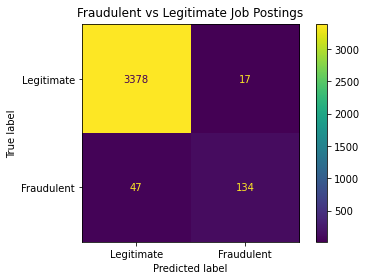

In [14]:
# Here we plot a confusion matrix.
# It shows us the rate of :
# 1. True positives: the cases in which we predicted a posting
#                    was fraudulent and we were correct.
#
# 2. True negatives: postings that were predicted as not fraudulent
#                    and were not.
#
# 3. False Positives: Postings that were determined to be fraudulent but
#                     were not.
#
# 4. False Negatives: Postings that were determined to be non fraudulent
#                     but actually were.

plot_confusion_matrix(model, X_val, +
                             y_val,
                             display_labels = ['Legitimate', 'Fraudulent'])

plt.title('Fraudulent vs Legitimate Job Postings', pad=8);

In [15]:
# Here we will calculate the accuracy, precision and recall
# based on our confusion matrix. 

# To calculate accuracy from the confusion matrix,
# we divide the sum of tp and tn by the sum of
# tp, tn, fp, fn.
conf_acc = (3378 + 134) / (3378 + 134 + 47 + 134)

# To calculate precision from the confusion matrix,
# we divide tp by the sum of tp and tn.
conf_prec = 3378 / (3378 + 17)

# To calculate recall from the confusion matrix,
# we divide the tp rate by the sum of tp and fp.
conf_recall = 3378 / (3378 + 47)

print('Accuracy:', conf_acc)
print('Precision:', conf_prec)
print('Recall:', conf_recall)

Accuracy: 0.950988356349851
Precision: 0.9949926362297496
Recall: 0.9862773722627737


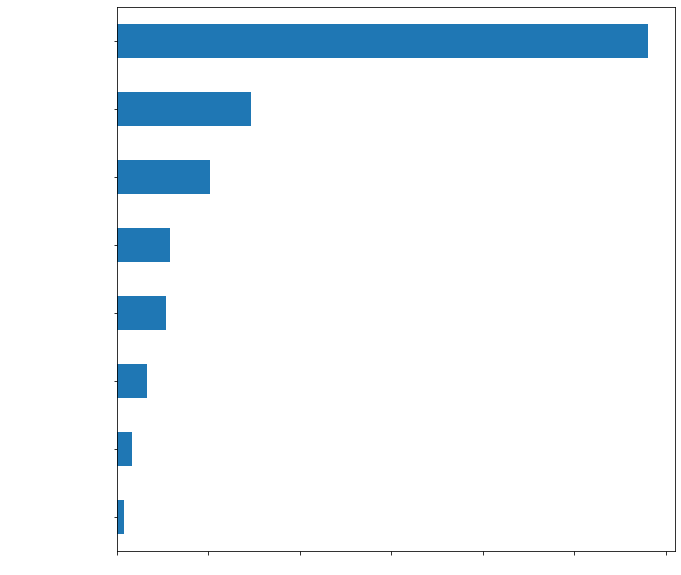

In [16]:
# Here we calculate feature importance. In other words,
# the features that played the biggest part in the prediction.

classifier = model.named_steps['randomforestclassifier']
feature_names = model.named_steps['ordinalencoder'].feature_names
feat_importances = classifier.feature_importances_
importances = pd.Series(feat_importances, index = feature_names).sort_values()

plt.figure(figsize=(10,10))
importances.tail(10).plot(kind='barh')
plt.xticks(color='white')
plt.yticks(color='white');

In [17]:
# Here we use the classification report to see compared
# precision (percentage of correctly predicted job postings), also
# known as true positives and recall, which is the actual positives
# that were correctly identified and recall (percentage of

print(classification_report(y_val, model.predict(X_val), target_names=['Legitimate', 'Fraudulent']))

              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99      3395
  Fraudulent       0.89      0.74      0.81       181

    accuracy                           0.98      3576
   macro avg       0.94      0.87      0.90      3576
weighted avg       0.98      0.98      0.98      3576



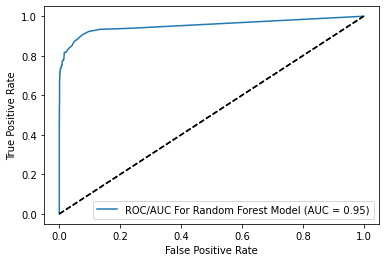

In [18]:
rf_model_roc = plot_roc_curve(model, X_val, y_val, name = 'ROC/AUC For Random Forest Model')

plt.plot([(0,0), (1,1)], color = 'black', linestyle = '--');

For the second, we will create a logistic regression model. As with the
random forest classifier, we are still attempting to predict a discrete value.

In [19]:
model_lr = make_pipeline(

                         OrdinalEncoder(),
                         StandardScaler(),
                         SimpleImputer(),
                         LogisticRegression(n_jobs=-1,
                                            max_iter = 50,
                                            random_state=42,
                                            )
                        )

model_lr.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['employment_type', 'required_experience',
                                      'industry', 'function'],
                                mapping=[{'col': 'employment_type',
                                          'data_type': dtype('O'),
                                          'mapping': Full-time    1
NaN          2
Contract     3
Part-time    4
Other        5
Temporary    6
dtype: int64},
                                         {'col': 'required_experience',
                                          'data_type': dtype('O'),
                                          'mapping': NaN                 1
Associate           2
Entry level         3
Mid-Senior level    4...
Product Management        25
Business Analyst          26
Art/Creative              27
Research                  28
Quality Assurance         29
Science                   30
Consulting                31
Project Management        32
Manufacturing 

In [20]:
print('Training Accuracy:',model_lr.score(X_train,y_train))
print('Validation Accuracy:',model_lr.score(X_val, y_val))

Training Accuracy: 0.9521812080536913
Validation Accuracy: 0.9493847874720358


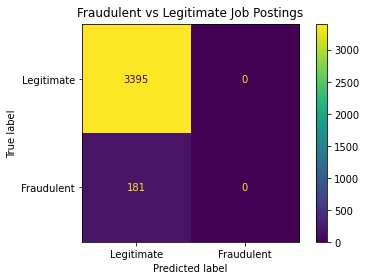

In [21]:
plot_confusion_matrix(model_lr, X_val, y_val,
                      display_labels = ['Legitimate', 'Fraudulent'])

plt.title('Fraudulent vs Legitimate Job Postings', pad=8);

In [22]:
lr_conf_acc = (3390 + 89) / (3390 + 89 + 92 + 5)

lr_conf_recall = 3390  / (3390 + 5)

lr_conf_presc = 3390 / (3390 + 92)

print('LogisticRegression Model Confusion Accuracy', lr_conf_acc)
print('LogisticRegression Model Confusion Recall: ', lr_conf_recall)
print('LogisticRegression Model Confusion Precision:', lr_conf_presc)

LogisticRegression Model Confusion Accuracy 0.9728747203579419
LogisticRegression Model Confusion Recall:  0.9985272459499264
LogisticRegression Model Confusion Precision: 0.9735784032165422


In [23]:
print(classification_report(y_val, model.predict(X_val), target_names=['Legitimate', 'Fraudulent']))

              precision    recall  f1-score   support

  Legitimate       0.99      0.99      0.99      3395
  Fraudulent       0.89      0.74      0.81       181

    accuracy                           0.98      3576
   macro avg       0.94      0.87      0.90      3576
weighted avg       0.98      0.98      0.98      3576



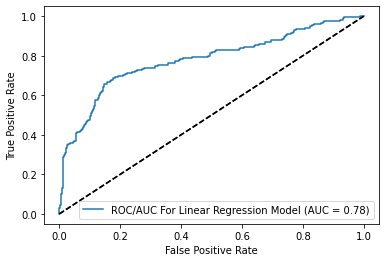

In [24]:
lr_model_roc = plot_roc_curve(model_lr, X_val, y_val, name = 'ROC/AUC For Linear Regression Model')

plt.plot([(0,0), (1,1)], color = 'black', linestyle = '--');

Text(0.5, 1.0, 'Logistic regression')

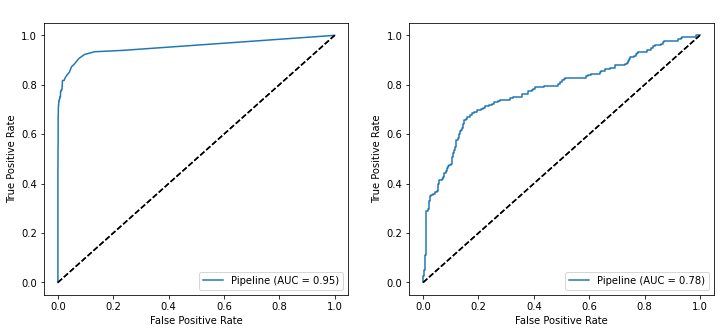

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols =2, nrows = 1, figsize = (12,5))

rf_model_roc = plot_roc_curve(model, X_val, y_val, ax= ax1)
lr_model_roc = plot_roc_curve(model_lr, X_val, y_val, ax = ax2)

ax1.plot([(0,0), (1,1)], color = 'black', linestyle = '--')
ax2.plot([(0,0), (1,1)], color = 'black', linestyle = '--')

ax1.set_title('Random Forest', color = 'white')
ax2.set_title('Logistic regression', color = 'white')



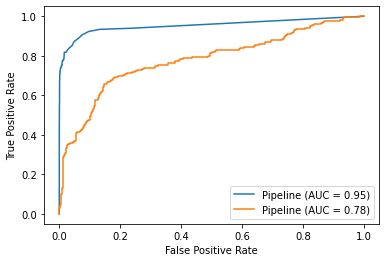

In [26]:
rf = plot_roc_curve(model, X_val, y_val)
lr = plot_roc_curve(model_lr, X_val, y_val, ax = rf.ax_)
plt.show()

In [27]:
xgb_model = make_pipeline(

                            OrdinalEncoder(),
                            SimpleImputer(),
                            XGBClassifier(n_estimators = 50, 
                                          n_jobs = -1, 
                                          random_state = 42,
                                         )
                        )

xgb_model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['employment_type', 'required_experience',
                                      'industry', 'function'],
                                mapping=[{'col': 'employment_type',
                                          'data_type': dtype('O'),
                                          'mapping': Full-time    1
NaN          2
Contract     3
Part-time    4
Other        5
Temporary    6
dtype: int64},
                                         {'col': 'required_experience',
                                          'data_type': dtype('O'),
                                          'mapping': NaN                 1
Associate           2
Entry level         3
Mid-Senior level    4...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max

In [28]:
print('Training Accuracy:', xgb_model.score(X_train, y_train))
print('Validation Accuracy:', xgb_model.score(X_train, y_train))

Training Accuracy: 0.9858780760626398
Validation Accuracy: 0.9858780760626398


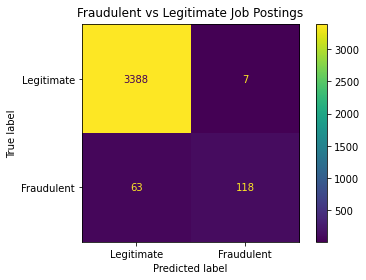

In [29]:
plot_confusion_matrix(xgb_model, X_val, y_val,
                      display_labels = ['Legitimate', 'Fraudulent'])

plt.title('Fraudulent vs Legitimate Job Postings', pad=8);